## Setup

In [1]:
# Packages
import pandas as pd
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
import math

In [2]:
# Import data
tor_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_train_set_no_zeros.csv")


# Quick inspection
tor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8308 entries, 0 to 8307
Data columns (total 35 columns):
DAMAGE_PROPERTY       8308 non-null float64
DURATION_SECONDS      8308 non-null float64
BEGIN_LAT             8308 non-null float64
BEGIN_LON             8308 non-null float64
TOR_LENGTH            8308 non-null float64
TOR_WIDTH             8308 non-null float64
YEAR                  8308 non-null float64
MULTI_VORT_IND        8308 non-null int64
OPEN_WATER_PROP       8308 non-null float64
DEV_OPEN_PROP         8308 non-null float64
DEV_LOW_PROP          8308 non-null float64
DEV_MED_PROP          8308 non-null float64
DEV_HIGH_PROP         8308 non-null float64
BARREN_LAND_PROP      8308 non-null float64
DECID_FOREST_PROP     8308 non-null float64
EVERGR_FOREST_PROP    8308 non-null float64
MIXED_FOREST_PROP     8308 non-null float64
SHRUB_SCRUB_PROP      8308 non-null float64
GRASS_LAND_PROP       8308 non-null float64
PASTURE_HAY_PROP      8308 non-null float64
CULT_CROPS_PROP

In [3]:
# Seperating variables
# The dependent variables
tornado_outcomes = tor_df.iloc[:, [0]]


# Quick inspection
tornado_outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8308 entries, 0 to 8307
Data columns (total 1 columns):
DAMAGE_PROPERTY    8308 non-null float64
dtypes: float64(1)
memory usage: 65.0 KB


In [4]:
# The independent variables
tornado_features = tor_df.loc[:, ["DURATION_SECONDS",
                                  "TOR_LENGTH",
                                  "TOR_WIDTH",
                                  "YEAR",
                                  "MULTI_VORT_IND",
                                  "TOR_AREA",
                                  "DAY_OF_YEAR",
                                  "MONTH",
                                  "TIME"]]


# Quick inspection
tornado_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8308 entries, 0 to 8307
Data columns (total 9 columns):
DURATION_SECONDS    8308 non-null float64
TOR_LENGTH          8308 non-null float64
TOR_WIDTH           8308 non-null float64
YEAR                8308 non-null float64
MULTI_VORT_IND      8308 non-null int64
TOR_AREA            8308 non-null float64
DAY_OF_YEAR         8308 non-null float64
MONTH               8308 non-null float64
TIME                8308 non-null float64
dtypes: float64(8), int64(1)
memory usage: 584.2 KB


In [5]:
# Make the dependent variables into a numpy array
outcomes_array = tornado_outcomes.values


# Makes the numpy array into a torch Tensor
outcomes_Tensor = torch.from_numpy(outcomes_array)


# Quick inspection
outcomes_Tensor


 0.1532
 0.6540
 0.0873
   ⋮    
 0.5790
 0.1532
 0.2814
[torch.DoubleTensor of size 8308x1]

In [6]:
# Make the independent variables into a numpy array
features_array = tornado_features.values


# Make the numpy array into a torch Tensor
features_Tensor = torch.from_numpy(features_array)


# Quick inspection
features_Tensor


 0.0227 -0.4127 -0.7859  ...  -0.0068 -0.2947 -0.4531
-0.3046 -1.0358 -0.9368  ...  -0.1143 -0.2947  1.1092
 0.3520  0.0818 -0.9368  ...  -0.9653 -1.0297 -0.1038
          ...             ⋱             ...          
 0.5451  0.6778 -0.3589  ...  -0.7735 -1.0297 -1.5301
 0.0227 -0.4127 -0.7859  ...   0.8091  0.8078 -2.1918
 0.4583  0.9771 -0.3589  ...  -2.1091 -1.7647  0.5064
[torch.DoubleTensor of size 8308x9]

### Convert DoubleTensor to FloatTensor

In [7]:
# Changing dependent variables from a DoubleTensor to a FloatTensor
outcomes_Tensor = outcomes_Tensor.float()


# ...and for the independent variables
features_Tensor = features_Tensor.float()


# Quick check
features_Tensor


 0.0227 -0.4127 -0.7859  ...  -0.0068 -0.2947 -0.4531
-0.3046 -1.0358 -0.9368  ...  -0.1143 -0.2947  1.1092
 0.3520  0.0818 -0.9368  ...  -0.9653 -1.0297 -0.1038
          ...             ⋱             ...          
 0.5451  0.6778 -0.3589  ...  -0.7735 -1.0297 -1.5301
 0.0227 -0.4127 -0.7859  ...   0.8091  0.8078 -2.1918
 0.4583  0.9771 -0.3589  ...  -2.1091 -1.7647  0.5064
[torch.FloatTensor of size 8308x9]

## Round 1: One-Hidden-Layer Neural Network

In [8]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [9]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(9, 6),
                            torch.nn.ReLU(),
                            torch.nn.Linear(6, 1))

In [10]:
# Set the loss function
loss_fn = torch.nn.MSELoss(size_average=False)

In [11]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

In [12]:
# Get the iterations
iterations = list(range(0, 15000))

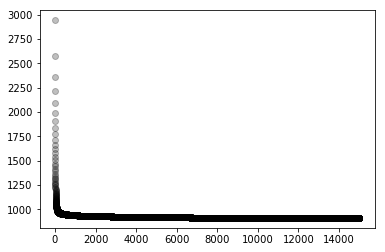

In [13]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [14]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

In [15]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
outcomes_Variable_resized = outcomes_Variable.resize(8308)


# Make the FloatTensor into a numpy.array
outcomes_array = outcomes_Variable_resized.data.numpy()


# Make the numpy.array into a list
outcomes_list = outcomes_array.tolist()

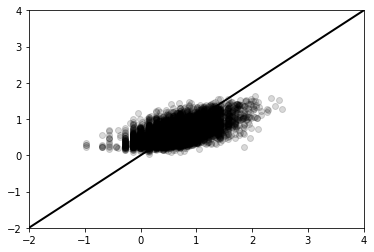

In [16]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 1.1: Validation Set Performance

In [17]:
# Import data
valid_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_cv_set_no_zeros.csv")


# Validation set outcomes
valid_outcomes = valid_df.iloc[:, [0]]


# Make the validation outcomes into a numpy array
valid_outcomes_array = valid_outcomes.values


# Makes the numpy array into a torch Tensor
valid_outcomes_Tensor = torch.from_numpy(valid_outcomes_array)


# Changing validation outcomes from a DoubleTensor to a FloatTensor
valid_outcomes_Tensor = valid_outcomes_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_outcomes_Variable = Variable(valid_outcomes_Tensor)


# Quick check
valid_outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2808 entries, 0 to 2807
Data columns (total 1 columns):
DAMAGE_PROPERTY    2808 non-null float64
dtypes: float64(1)
memory usage: 22.0 KB


In [18]:
# Validation set predictors
valid_predictors = valid_df.loc[:, ["DURATION_SECONDS",
                                    "TOR_LENGTH",
                                    "TOR_WIDTH",
                                    "YEAR",
                                    "MULTI_VORT_IND",
                                    "TOR_AREA",
                                    "DAY_OF_YEAR",
                                    "MONTH",
                                   "TIME"]]


# Make the validation predictors into a numpy array
valid_predictors_array = valid_predictors.values


# Makes the numpy array into a torch Tensor
valid_predictors_Tensor = torch.from_numpy(valid_predictors_array)


# Changing validation predictors from a DoubleTensor to a FloatTensor
valid_predictors_Tensor = valid_predictors_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_predictors_Variable = Variable(valid_predictors_Tensor)


# Quick check
valid_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2808 entries, 0 to 2807
Data columns (total 9 columns):
DURATION_SECONDS    2808 non-null float64
TOR_LENGTH          2808 non-null float64
TOR_WIDTH           2808 non-null float64
YEAR                2808 non-null float64
MULTI_VORT_IND      2808 non-null int64
TOR_AREA            2808 non-null float64
DAY_OF_YEAR         2808 non-null float64
MONTH               2808 non-null float64
TIME                2808 non-null float64
dtypes: float64(8), int64(1)
memory usage: 197.5 KB


In [19]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 306.4614
[torch.FloatTensor of size 1]

In [20]:
# Computing the total sum of squares
# Get a torch Variable of the mean outcome
# Compute mean value
valid_outcomes_mean = (sum(valid_outcomes_Variable) / len(valid_outcomes_Variable))
valid_outcomes_mean = valid_outcomes_mean.data.numpy()[0]

# Make that into a ndarray
valid_outcomes_mean = np.repeat(valid_outcomes_mean, len(valid_outcomes_Variable))

# Turn the array into a torch Tensor
valid_outcomes_mean = torch.from_numpy(valid_outcomes_mean)

# Turn that Tensor into a Variable
valid_outcomes_mean_Variable = Variable(valid_outcomes_mean)

# Compute the TSS
tot_sum_squares = loss_fn(valid_outcomes_mean_Variable, valid_outcomes_Variable)


# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.3553
[torch.FloatTensor of size 1]

In [21]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

In [22]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
valid_outcomes_Variable_resized = valid_outcomes_Variable.resize(2808)


# Make the FloatTensor into a numpy.array
valid_outcomes_array = valid_outcomes_Variable_resized.data.numpy()


# Convert back to log scale
valid_outcomes_array = valid_outcomes_array*5.407597 + 7.688844


# Make the numpy.array into a list
valid_outcomes_list = valid_outcomes_array.tolist()

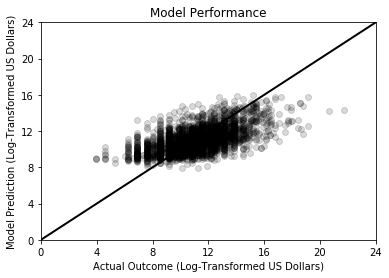

In [23]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [24]:
model[(0)].weight

Parameter containing:
-0.1775  0.2831  0.3477 -0.2360  0.3940 -0.1415 -0.1025  0.2012 -0.2554
 0.1920  0.1216  0.3102 -0.0357 -0.2655 -0.0377 -0.0837  0.0797  0.1610
 0.2531  0.5158 -0.0272 -0.1745  0.1305 -0.3651 -0.1094 -0.2943 -0.2044
 0.0496  0.0663  0.1262 -0.9215 -0.1426  0.1501 -0.4190  0.1191 -0.6772
-0.0614 -0.3018  0.0420  0.0146  1.3208 -0.2642  0.0114 -0.0131 -0.0296
 0.3273  0.2930 -0.5129  0.0358 -0.4569  0.0325 -0.0582 -0.1393 -0.0187
[torch.FloatTensor of size 6x9]

In [25]:
model[(2)].weight

Parameter containing:
 0.3824  0.3294  0.2328 -0.1090 -0.2740 -0.2334
[torch.FloatTensor of size 1x6]

## Round 2: Two-Hidden-Layer Neural Network

In [26]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [27]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(9, 6),
                            torch.nn.ReLU(),
                            torch.nn.Linear(6, 4),
                            torch.nn.ReLU(),
                            torch.nn.Linear(4, 1))

In [28]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

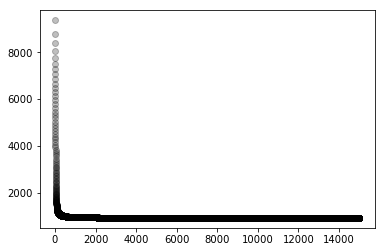

In [29]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [30]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

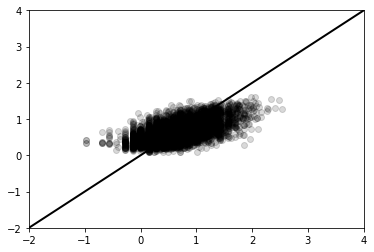

In [31]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 2.1: Validation Set Performance

In [32]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 306.3725
[torch.FloatTensor of size 1]

In [33]:
# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.3555
[torch.FloatTensor of size 1]

In [34]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

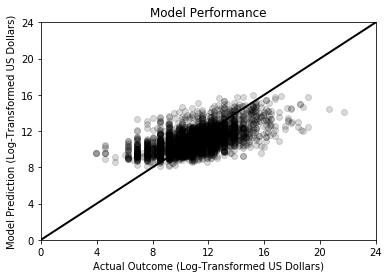

In [35]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [36]:
model[(0)].weight

Parameter containing:
 0.1961 -0.5987 -0.3784  0.0462 -0.5431  0.5748  0.0645 -0.1636  0.0927
 0.1509  0.0074  0.2477 -0.0128  0.2057  0.4260 -0.1541  0.4091 -0.1733
-0.2289 -0.1799 -0.1265  0.0243  0.0047  0.3083  0.1261  0.1408 -0.1042
-0.2382  0.3318  0.0059 -0.3464 -0.5359  0.2629  0.3289 -0.0053  0.1428
-0.1267  0.2359  0.1605 -0.0794 -0.2700  0.2356 -0.1504 -0.2388 -0.0621
 0.3088  0.0568  0.1924  0.0224  0.3632  0.0587  0.1851 -0.1259  0.2202
[torch.FloatTensor of size 6x9]

In [37]:
model[(2)].weight

Parameter containing:
 0.6558  0.4155 -0.0873 -0.4691  0.1612  0.0160
 0.6547  0.4177 -0.1089  0.5644  0.2642  0.3222
 0.3652  0.2100  0.3512  0.0680  0.4183  0.2003
 0.0988 -0.0734 -0.1460 -0.5254  0.1300 -0.3337
[torch.FloatTensor of size 4x6]

In [38]:
model[(4)].weight

Parameter containing:
 0.1050  0.1962  0.4639 -0.2182
[torch.FloatTensor of size 1x4]

## Round 3: Three-Hidden-Layer Neural Network

In [39]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [40]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(9, 6),
                            torch.nn.ReLU(),
                            torch.nn.Linear(6, 4),
                            torch.nn.ReLU(),
                            torch.nn.Linear(4, 3),
                            torch.nn.ReLU(),
                            torch.nn.Linear(3, 1))

In [41]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

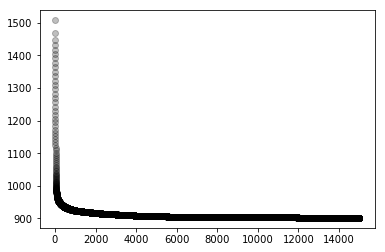

In [42]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [43]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

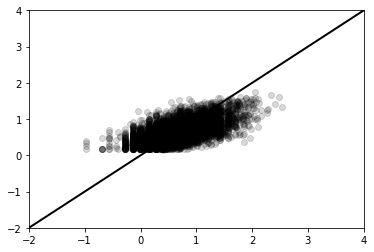

In [44]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 3.1: Validation Set Performance

In [45]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 303.8239
[torch.FloatTensor of size 1]

In [46]:
# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.3609
[torch.FloatTensor of size 1]

In [47]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

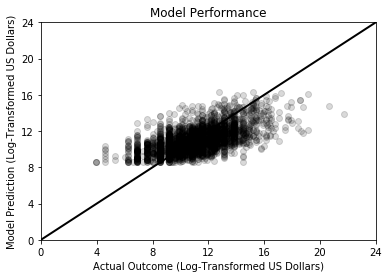

In [48]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [49]:
model[(0)].weight

Parameter containing:
 0.0028  0.6229 -0.1823  0.1109 -0.4437 -0.5834 -0.4082  0.1163 -0.1941
 0.2332 -0.0994  0.1258  0.0667 -1.1356  0.1917 -0.1563  0.0885 -0.2081
 0.0185  0.5066  0.3269  0.0235  0.2519 -0.5953 -0.0817  0.0391 -0.1594
-0.1244  0.0061  0.3118 -0.1970  0.3783  0.0997  0.1679  0.1490  0.1589
 0.2514  0.1958 -0.1773  0.0503  0.0361  0.0553 -0.2458 -0.1286  0.2088
-0.2195  0.1431 -0.3194 -0.0375  0.1896  0.4173 -0.2817  0.0726 -0.0731
[torch.FloatTensor of size 6x9]

In [50]:
model[(2)].weight

Parameter containing:
-0.3805  0.4418  0.0865  0.3633  0.0698  0.3345
-0.5798  0.1783  0.9872  0.3400  0.3894  0.1499
 0.2217 -1.0348 -0.0397 -0.1029  0.3246 -0.3161
 0.1942 -0.0805 -0.7308  0.0078 -0.3369  0.7643
[torch.FloatTensor of size 4x6]

In [51]:
model[(4)].weight

Parameter containing:
 0.6682 -1.1177  0.0172  0.1858
 0.5502 -1.9143  0.1665  0.1770
 0.6417  0.7200  0.9872  0.8463
[torch.FloatTensor of size 3x4]

In [52]:
model[(6)].weight

Parameter containing:
-2.5037 -2.1515  0.6724
[torch.FloatTensor of size 1x3]

## Round 4: Four-Hidden-Layer Neural Network

In [53]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [54]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(9, 6),
                            torch.nn.ReLU(),
                            torch.nn.Linear(6, 4),
                            torch.nn.ReLU(),
                            torch.nn.Linear(4, 3),
                            torch.nn.ReLU(),
                            torch.nn.Linear(3, 2),
                            torch.nn.ReLU(),
                            torch.nn.Linear(2, 1))

In [55]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

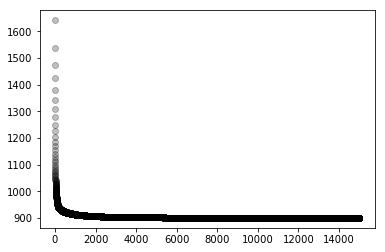

In [56]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [57]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

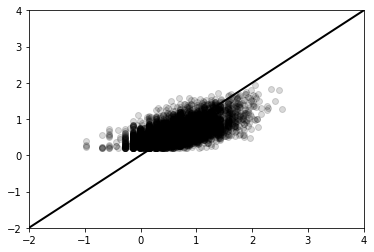

In [58]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 4.1: Validation Set Performance

In [59]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 306.4662
[torch.FloatTensor of size 1]

In [60]:
# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.3553
[torch.FloatTensor of size 1]

In [61]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

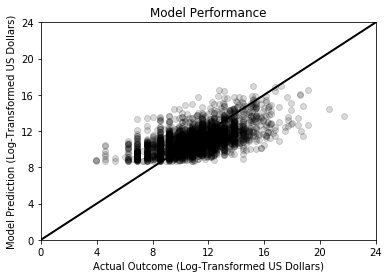

In [62]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [63]:
model[(0)].weight

Parameter containing:
-0.1274  0.2958  0.2615 -0.0169  0.0423 -0.2398  0.0958 -0.3053  0.0108
 0.0251  0.8189  0.1334 -0.2879 -0.3457 -0.4350  0.0407  0.0550  0.0321
-0.2085  0.1996  0.0304 -0.0857  0.1587  0.2148  0.0797  0.0160 -0.2356
-0.0731 -0.1534 -0.0105 -0.1421 -0.7054 -0.3851 -0.0059 -0.0254 -0.0255
 0.4157 -0.0904  0.4167  0.0254  0.4794 -0.0527 -0.0938  0.1223  0.0265
-0.0826  0.1454  0.3094 -0.0589 -0.4854 -0.0239 -0.1346 -0.0001  0.1282
[torch.FloatTensor of size 6x9]

In [64]:
model[(2)].weight

Parameter containing:
 0.3985  0.2355  0.4294 -0.0265  0.0028  0.4208
 0.5238  0.3778  0.2895 -0.3193  0.1718  0.0768
-0.4331  0.3706  0.0562 -0.7445 -0.3396  0.0066
-0.5953 -0.2178  0.2567  0.0133  0.2309  0.4542
[torch.FloatTensor of size 4x6]

In [65]:
model[(4)].weight

Parameter containing:
 0.3041 -0.5630  0.4594  0.1799
 0.3888  0.0302 -0.6765 -0.1095
 0.5162  0.6671 -0.6498  0.2855
[torch.FloatTensor of size 3x4]

In [66]:
model[(6)].weight

Parameter containing:
-0.6836  0.3359  0.7587
-0.0418 -0.4397 -0.4633
[torch.FloatTensor of size 2x3]

In [67]:
model[(8)].weight

Parameter containing:
 0.7403 -0.6409
[torch.FloatTensor of size 1x2]

## Round 5: Linear Regression

In [68]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [69]:
# Make the neural network - really a regression
model = torch.nn.Sequential(torch.nn.Linear(9, 1))

In [70]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(15000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

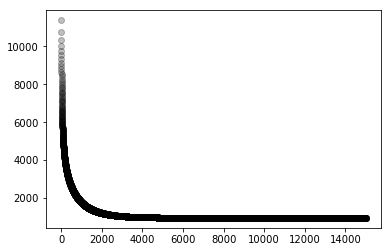

In [71]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [72]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(8308)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

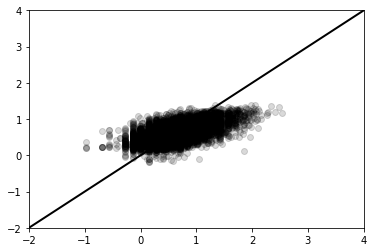

In [73]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 5.1: Validation Set Performance

In [74]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 313.2346
[torch.FloatTensor of size 1]

In [75]:
# Grab the residual sum of squares
resid_sum_squares = loss_fn(y_valid_pred, valid_outcomes_Variable)


# Compute R squared
R_squared = 1 - (resid_sum_squares / tot_sum_squares)

R_squared

Variable containing:
 0.3411
[torch.FloatTensor of size 1]

In [76]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(2808)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

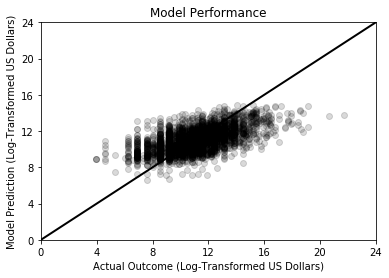

In [77]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [78]:
model[(0)].weight

Parameter containing:
 0.0054  0.1204  0.1414 -0.0292  0.0227  0.0137 -0.0324  0.0293  0.0093
[torch.FloatTensor of size 1x9]